In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
import torch.optim as optim
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from calflops import calculate_flops
work_path = "/home/re6125015/DeepL/images"
os.chdir(work_path)

/opt/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
os.getpid()

243121

In [3]:
def load_npz_data(file_path):
    loaded = np.load(file_path)
    X = loaded['array1']  # Adjust 'array1' if your image data key is different
    y = loaded['array2']  # Adjust 'array2' if your label data key is different
    return X, y

X_train, y_train = load_npz_data('train.npz')
X_val, y_val = load_npz_data('val.npz')
X_test, y_test = load_npz_data('test.npz')

In [4]:
class NPZDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)  # Ensure label is torch.long

In [5]:
res = 84
transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((res, res)),  # ResNet typically uses 224x224 input images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Create datasets
train_dataset = NPZDataset(X_train, y_train, transform=transform)
val_dataset = NPZDataset(X_val, y_val, transform=transform)
test_dataset = NPZDataset(X_test, y_test, transform=transform)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

In [6]:
class DynamicSelectiveConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, stride=1, padding=1, bias=False, selected_channels='RGB'):
        super(DynamicSelectiveConvLayer, self).__init__()
        self.selected_channels = selected_channels.upper()
        self.valid_channels = {'R', 'G', 'B'}

        if not set(self.selected_channels).issubset(self.valid_channels):
            raise ValueError("selected_channels must be a combination of 'R', 'G', 'B'")

        # Mask to filter out unwanted channels
        channel_mask = [ch in self.selected_channels for ch in 'RGB']
        self.register_buffer('channel_mask', torch.tensor(channel_mask, dtype=torch.bool))

        # Determine actual input channels based on selection
        actual_in_channels = sum(channel_mask)

        self.weight_gen = nn.Sequential(
            nn.Linear(actual_in_channels, out_channels * actual_in_channels * kernel_size * kernel_size),
            nn.Tanh()  # Activation to control range of weights  ##Tanh / Sigmoid
        )
        self.bias = nn.Parameter(torch.zeros(out_channels))
        self.stride = stride
        self.padding = padding
        self.kernel_size = kernel_size
        self.out_channels = out_channels
        self.in_channels = actual_in_channels

    def forward(self, x):
        # Select channels
        x_selected = x[:, self.channel_mask, :, :]

        # Generate weights dynamically
        batch_size, _, _, _ = x_selected.size()
        avg_pool = F.adaptive_avg_pool2d(x_selected, 1).view(batch_size, -1)
        dynamic_weights = self.weight_gen(avg_pool).view(-1, self.out_channels, self.in_channels, self.kernel_size, self.kernel_size)

        # Convolve each batch separately
        output = [F.conv2d(x_selected[i].unsqueeze(0), dynamic_weights[i], self.bias, self.stride, self.padding) for i in range(batch_size)]
        return torch.cat(output, dim=0)

In [7]:
import torch.nn.functional as F

class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super().__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)

        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)
        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)
        return out

In [8]:
class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=1000, initial_channels=3, selected_channels='RGB'):
        super(ResNet, self).__init__()
        self.in_channels = 64  # Set initial number of input channels after first conv layer

        # Initial dynamic and selective convolution layer
        self.conv1 = DynamicSelectiveConvLayer(initial_channels, 64, kernel_size=3, stride=1, padding=1, bias=False, selected_channels=selected_channels)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)

        # Construct the layers of the ResNet using the block definitions
        self.layer1 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)

        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, out_channels, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_channels != out_channels * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_channels, out_channels * block.expansion, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_channels * block.expansion)
            )

        layers = []
        layers.append(block(self.in_channels, out_channels, stride, downsample))
        self.in_channels = out_channels * block.expansion
        for _ in range(1, blocks):
            layers.append(block(self.in_channels, out_channels))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        x = self.fc(x)

        return x

In [9]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

selected_channels = 'RGB'
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50, selected_channels=selected_channels).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)

# # Define a StepLR scheduler
# scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min')

In [10]:
batch_size = 64
input_shape = (batch_size, 3, 84, 84)
flops, macs, params = calculate_flops(model=model, 
                                      input_shape=input_shape,
                                      output_as_string=True,
                                      output_precision=4)
print("FLOPs:%s   MACs:%s   Params:%s \n" %(flops, macs, params))


------------------------------------- Calculate Flops Results -------------------------------------
Notations:
number of parameters (Params), number of multiply-accumulate operations(MACs),
number of floating-point operations (FLOPs), floating-point operations per second (FLOPS),
fwd FLOPs (model forward propagation FLOPs), bwd FLOPs (model backward propagation FLOPs),
default model backpropagation takes 2.00 times as much computation as forward propagation.

Total Training Params:                                                  11.2 M  
fwd MACs:                                                               250.713 GMACs
fwd FLOPs:                                                              502.252 GFLOPS
fwd+bwd MACs:                                                           752.138 GMACs
fwd+bwd FLOPs:                                                          1.5068 TFLOPS

-------------------------------- Detailed Calculated FLOPs Results --------------------------------
Each mod

In [11]:
num_epochs = 50
early_stopping_counter = 0
best_val_loss = float('inf')

for epoch in range(num_epochs):
    model.train()  # Set model to training mode
    running_loss = 0.0
    correct = 0
    total = 0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()  # Zero the parameter gradients

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize the model

        # Statistics
        running_loss += loss.item() * inputs.size(0)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    epoch_loss = running_loss / total
    epoch_acc = correct / total * 100

    # Validation
    model.eval()  # Set model to evaluation mode
    val_loss = 0.0
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in val_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_loss /= total
    val_acc = correct / total * 100

    print(f'Epoch {epoch + 1}: Train Loss: {epoch_loss:.4f} Train Acc: {epoch_acc:.2f}% Val Loss: {val_loss:.4f} Val Acc: {val_acc:.2f}%')

    # # Set scheduler after each epoch
    # scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), f'part1/best_model_v1_{res}.pth')
        early_stopping_counter = 0
    else:
        early_stopping_counter += 1

    if early_stopping_counter > 2:  # stops if no improvement after 3 epochs
        print("Early stopping triggered.")
        break

Epoch 1: Train Loss: 3.4334 Train Acc: 10.89% Val Loss: 3.1865 Val Acc: 16.44%
Epoch 2: Train Loss: 2.9415 Train Acc: 19.90% Val Loss: 2.8253 Val Acc: 22.67%
Epoch 3: Train Loss: 2.6638 Train Acc: 26.35% Val Loss: 2.6044 Val Acc: 26.22%
Epoch 4: Train Loss: 2.3639 Train Acc: 33.13% Val Loss: 2.4158 Val Acc: 31.56%
Epoch 5: Train Loss: 2.0650 Train Acc: 40.13% Val Loss: 2.0737 Val Acc: 36.89%
Epoch 6: Train Loss: 1.8083 Train Acc: 46.82% Val Loss: 1.8802 Val Acc: 45.11%
Epoch 7: Train Loss: 1.6021 Train Acc: 51.97% Val Loss: 1.8297 Val Acc: 45.33%
Epoch 8: Train Loss: 1.4236 Train Acc: 56.77% Val Loss: 1.6156 Val Acc: 50.89%
Epoch 9: Train Loss: 1.2705 Train Acc: 60.74% Val Loss: 1.5691 Val Acc: 53.78%
Epoch 10: Train Loss: 1.1336 Train Acc: 64.43% Val Loss: 1.6101 Val Acc: 53.56%
Epoch 11: Train Loss: 1.0021 Train Acc: 68.11% Val Loss: 1.7462 Val Acc: 52.22%
Epoch 12: Train Loss: 0.8770 Train Acc: 71.75% Val Loss: 1.6705 Val Acc: 52.89%
Early stopping triggered.


In [12]:
print(best_val_loss)

1.569148020810551


In [13]:
model = ResNet(BasicBlock, [2, 2, 2, 2], num_classes=50, selected_channels='RGB')  # Ensure this matches the model architecture
model.load_state_dict(torch.load(f'part1/best_model_v1_{res}.pth'))
model.eval()  # Set the model to evaluation mode
model.to(device)  # Move model to the appropriate device (CPU or GPU)

ResNet(
  (conv1): DynamicSelectiveConvLayer(
    (weight_gen): Sequential(
      (0): Linear(in_features=3, out_features=1728, bias=True)
      (1): Tanh()
    )
  )
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv

In [14]:
# Function to make predictions and optionally evaluate the model
def predict(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)
    
    all_predictions = []
    all_labels = []  # Optional, only if labels are available in the test set

    with torch.no_grad():  # No need to track gradients for predictions
        for inputs, labels in test_loader:
            inputs = inputs.to(devi
                               ce)
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())  # Optional

    return all_predictions, all_labels

# Get predictions and labels
predictions, labels = predict(model, test_loader)

In [15]:
if labels:
    accuracy = accuracy_score(labels, predictions) * 100
    print(f"Accuracy on test data: {accuracy:.2f}%")

Accuracy on test data: 56.67%


In [16]:
# Example of saving predictions to a CSV file
result_df = pd.DataFrame({'PredictedLabel': predictions})
result_df.to_csv(f'part1/predict_rgb_v1_{res}.csv', index=False)

In [17]:
# Print classification report
print("Classification Report:")
print(classification_report(labels, predictions))

# Print confusion matrix
print("Confusion Matrix:")
cm = confusion_matrix(labels, predictions)
print(cm)

Classification Report:
              precision    recall  f1-score   support

           0       0.45      0.56      0.50         9
           1       0.55      0.67      0.60         9
           2       1.00      0.22      0.36         9
           3       0.67      0.67      0.67         9
           4       0.67      0.67      0.67         9
           5       0.47      0.89      0.62         9
           6       1.00      0.44      0.62         9
           7       0.57      0.44      0.50         9
           8       0.23      0.67      0.34         9
           9       0.22      0.22      0.22         9
          10       0.00      0.00      0.00         9
          11       0.25      0.11      0.15         9
          12       0.78      0.78      0.78         9
          13       0.50      0.22      0.31         9
          14       0.60      0.33      0.43         9
          15       0.75      0.67      0.71         9
          16       0.80      0.44      0.57         9
    

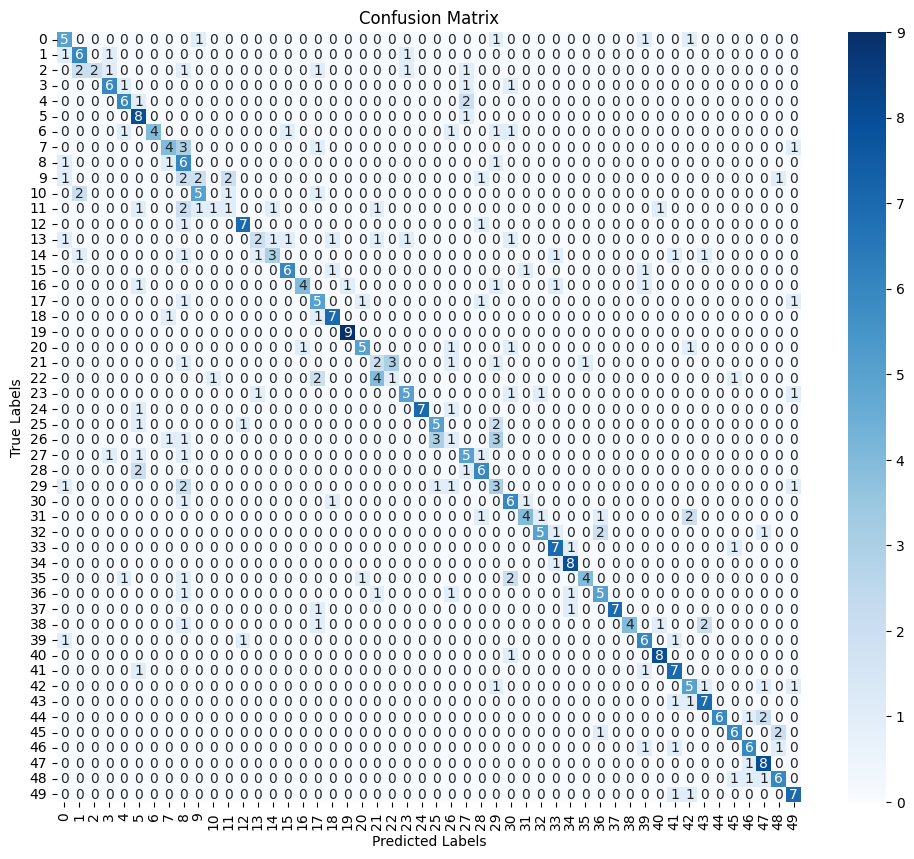

In [18]:
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()